![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Transferencia de aprendizaje: algunos ejemplos

### Aprendizaje Automático Aplicado

### Maestría en Ciencia de Datos

**Julio Waissman**, 2022

[Abrir en google Colab](https://colab.research.google.com/github/mcd-unison/aaa-curso/blob/main/ejemplos/transfer.ipynb)

## Introducción

En esta libreta vamos a presentar una colección de aplicaciones que se pueden realizar utilizando modelos preentrenados. La mayoría de las aplicaciones provienen de [tensorFlow Hub](https://www.tensorflow.org/hub) para explotar modelos ya revisados y validados. 

Esta es la base para buscar otros modelos y otras aplicaciones posibles.

In [31]:
#@title
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

## 1. Tranferencia de estilo

Tomado de [este ejemplo](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) y basado en el código del modelo en [magenta](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization) y la publicación:

[Explorar la estructura de un tiempo real, la red arbitraria estilización artística neuronal](https://arxiv.org/abs/1705.06830) . *Golnaz Ghiasi, Honglak Lee, Manjunath Kudlur, Vincent Dumoulin, Jonathon Shlens*, Actas de la Conferencia British Machine Vision (BMVC), 2017.

Empecemos importando las librerías que vamos a necesitar:

In [ ]:
# Para descargar las imagenes de estilo y contenido
import functools
import os

# Para graficar las imágenes
from matplotlib import gridspec
import matplotlib.pylab as plt

# Las que no pueden faltar
import numpy as np
import tensorflow as tf

# Para obtener los modelos preentrenados
import tensorflow_hub as hub

# Vamos viendo un poco de información
print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Vamos primero a definir algunas funciones para descargar las imágenes y para visualizarlas. 

Es importante aqui hablar sobre decoradores en python, si es que no los conocen. En este caso el decorador (de las herramientas de programación funcional de python) es para agregar **memoización** a la función. Esto es, que si la función ya se ejecuto una vez con esas entradas, guadre la salida en una memoria cache, para no tener que recalcularlo cada vez.


In [6]:
def crop_center(image):
  """
  Recibe una imagen de (3, n, m) y regresa
  una imagen cuadrada de (3, min(n,m), min(n,m))
  centrada
  
  """
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape
  )
  
  return image

def show_n(images, titles=('',)):
  """
  Muestra una serie de imagenes en forma horizontal
  y les agrega los títulos correspondientes

  """
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()


@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """
  Loads and preprocesses images.
  Memoization to prevent download multiple times the same image
  
  """
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(
      os.path.basename(image_url)[-128:], image_url
  )

  # Load and convert to float32 numpy array, 
  # add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32
  )[tf.newaxis, ...] 

  # Crop image an resize 
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  
  return img



Vamos ahora a cargar unas imágenes

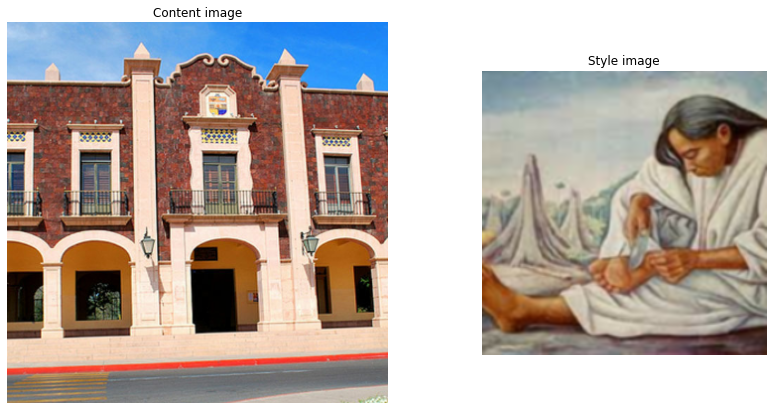

In [28]:
content_image_url = 'https://proyectopuente.com.mx/wp-content/uploads/2021/03/Unison-2.jpg'
style_image_url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvjSkzPQVNjS5XOWmOwTdOdY_PaXB4T9KNW0cJIw3LIsL0zCZuhApTOfu7D0yD8dj_PhI&usqp=CAU'  
output_image_size = 384 

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)

# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

Y ahora vamos a cargar el modelo preentrenado, el cual podemos revisar en la [página de TensorFlow Hub de este modelo](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2)

In [29]:
hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

Y simplemente lo ejecutamos y vemos el resultado

In [ ]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(
    tf.constant(content_image), 
    tf.constant(style_image)
)
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.

show_n(
    [content_image, style_image, stylized_image], 
    titles=['Original content image', 'Style image', 'Stylized image']
)

## 2. Reentrenamiento de un clasificador de imágenes

Tomado de [este ejemplo](https://www.tensorflow.org/hub/tutorials/tf2_image_retraining). 

Esta sección muestra cómo reutilizar un modelo existente  para clasificar cinco especies de flores. Se va a utilizar un modelo entrenado en el conjunto de datos ImageNet y guardado en TensorFlow Hub. Se van a mantener las capas de extracción de características y unicamente se va a modificar el clasificador. Opcionalmente, el extractor de características se puede entrenar ("ajustar") junto con el clasificador recién agregado.

Vamos primero cargando las librerias necesarias (aún las ya cargadas previamente, solo para facilitar el copiado/pegado en otro problema). De hecho `itertools` es el único módulo que no habíamos cargado previamente.

In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

Vamos ahora a seleccionar un modelo a descargar. Para esto vamos a poner una lista (tomada obviamente del tutorial desarrollado por el equipo de TensorFlow Hub) de los modelos disponibles, así como el tamaño de las imágenes que usa cada uno de los modelos. Los vamos a guardar en un diccionario:

In [ ]:
model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

print('Los modelos que podemos escoger son los siguientes:')

print('\n'.join(model_handle_map.keys()))

Y ahora si, seleccionamos nuestro modelo, el número de pixeles que maneja de imágenes de entrada y el tamaño del minibatch para reentrenar

In [ ]:
model_name = "efficientnetv2-xl-21k" 

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Modelo seleccionado: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Tamaño de la imagen: {IMAGE_SIZE}")

BATCH_SIZE = 16

Y ahora vamos a cargar el conjunto de imágenes a clasificar (lo que haríamops en cualquier problema propio que tuvieramos que solucionar).

In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

Ahora vamos a procesar los datos, y para eso vamos a usar el [modulo ``tf.data`](https://www.tensorflow.org/guide/data?hl=en) que permite crear *pipelines* para consumir (potencialmente) grandes cantidades de datos.

Vamos a seleccionar un conjunto de entrenamiento con el 80% de los datos. Se separan los valores de salida y se generan minibatches de tamaño `BATCH_SIZE``. Se utiliza `tf.data.repeat()` para asegurar que se provea en forma indefinida de minibatches para el entrenamiento.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=.20,
  subset="training",
  label_mode="categorical",
  # Seed needs to provided when using validation_split and shuffle = True.
  # A fixed seed is used so that the validation set is stable across runs.
  seed=123,
  image_size=IMAGE_SIZE,
  # Un dato por batch solo para sacar el tamaño de la muestra
  batch_size=1 
)
train_size = train_ds.cardinality().numpy()

class_names = tuple(train_ds.class_names)

# Ahora si, hacenmos batches de tamaño BATCH_SIZE
train_ds = train_ds.unbatch().batch(BATCH_SIZE)

train_ds = train_ds.repeat()

Vamos a hacer una serie de pasos para el entrenamiento.

1. Vamos a normalizar los datos entre 0 y 1
2. Si decidimos hacer aumentación de datos para el entrenamiento, entonces:
  1. Giro aleatorio entre -40 y 40 grados
  2. Translación aleatoria vertical entre 0 y 20%
  3. Translación aleatoria horizontal entre 0 y 20%
  4. Zoom aleatorio entre 0 y 20%
  5. Flip horizontal aleatorio

Todo el preprocesamiento se hace como un modelo neuronal que se integra en el *pipeline* de aprendizaje



In [6]:
do_data_augmentation = False

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

preprocessing_model = tf.keras.Sequential([normalization_layer])

if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(.4))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))

train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))


Ahora vamos a hacer el pipeline de validación, con los datos que se quedaron para validación (es necesario mantener una semilla fija para reproducibilidad).

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=.20,
  subset="validation",
  label_mode="categorical",
  # Seed needs to provided when using validation_split and shuffle = True.
  # A fixed seed is used so that the validation set is stable across runs.
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=1
)
valid_size = val_ds.cardinality().numpy()

val_ds = val_ds.unbatch().batch(BATCH_SIZE)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Vamos ahora a descargar el modelo seleccionado como capas internas de `Keras` de un modelo propio, donde se elimina la última capa para integrar la capa propia que vamos a hacer de nuestro clasificador.

Si quisieramos entrenar, además de la última capa, los pesos de las capas del modelo descargado (lo que se conoce como *fine tunning*) sólo hay que cambiar el valor de la variable booleana, lo que permitira modificar capas internas del modelo.

In [ ]:
do_fine_tuning = False

print("Modelo basado en ", model_handle)

model = tf.keras.Sequential([
  # Define explicitamente el input shape 
  tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
  # Carga el modelo preentrenado, con o sin fine tunning
  hub.KerasLayer(model_handle, trainable=do_fine_tuning),
  # Dropout para ayudar a la generalización
  tf.keras.layers.Dropout(rate=0.2),
  # Capa de salida lineal del número de clases y con regularización
  tf.keras.layers.Dense(
      len(class_names),
      kernel_regularizer=tf.keras.regularizers.l2(0.0001)
  )
], name='Mi-modelo-bien-bonito')

# Construye el modelo haciendo explicito el tamaño de entrada
model.build((None,) + IMAGE_SIZE + (3,))

model.summary()

Ahora compilamos y decidimos que optimizador, función de pérdida y métricas utilizar

In [9]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(
      learning_rate=0.005, 
      momentum=0.9
  ), 
  loss=tf.keras.losses.CategoricalCrossentropy(
      from_logits=True, 
      label_smoothing=0.1
  ),
  metrics=['accuracy']
)

... y entrenamos (y guardamos la evolución en `hist`).

In [ ]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE

hist = model.fit(
    train_ds,
    epochs=5, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps
).history

Y ahora grafiquemos la función de pérdida y la métrica seleccionada por los *epochs* que escogimos simular.

In [ ]:
plt.figure()
plt.ylabel("Funcion de pérdida")
plt.xlabel("Pasos de aprendizaje")
#plt.ylim([0,1])
plt.plot(hist["loss"], label='Entrenamiento')
plt.plot(hist["val_loss"], label='Validación')

plt.figure()
plt.ylabel("% de error")
plt.xlabel("Pasos de aprendizaje")
#plt.ylim([0,1])
plt.plot(hist["accuracy"], label='Entrenamiento')
plt.plot(hist["val_accuracy"], label='Validación')

Probemos como se enviaría una imagen nueva al clasificador:

In [ ]:
# Con el iterador se obtiene un minibatch de imñagenes y clases
x, y = next(iter(val_ds)) 

# Tomemos la primer imagen y su indice
image = x[0, :, :, :]
true_index = np.argmax(y[0])

# Mostramos la imagen
plt.imshow(image)
plt.axis('off')
plt.show()

# Expande la imagen a (1, 224, 224, 3) para introducirla al modelo
prediction_scores = model.predict(np.expand_dims(image, axis=0))

# Obten el indice con mayor valor en la capa de salida
predicted_index = np.argmax(prediction_scores)

print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

Y si el modelo te gustó y lo quieres usar más adelate, sólamente hay que guardarlo.

In [ ]:
saved_model_path = f"/tmp/saved_flowers_model_{model_name}"
tf.saved_model.save(model, saved_model_path)

## 3. Detección de objetos con modelos preentrenados

Vamos a explorar como realizar la detección de objetos usando los modelos preentrenados disponibles en TensorFlow Hub. Esta es obtenida a partir de [esta libreta de colab](https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

Iniciamos cargando las librerías, aunque ya estén cargadas anteriormente, para facilitar el copiado y pegado en otros proyectos.

In [3]:
# Las imprecindibles
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

# Para mostrar las imágenes
import matplotlib.pyplot as plt

# Para descargar las imágenes
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# Para dibujar cuadritos en las imágenes.
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# Para medir el tiempo que toma.
import time


Y ahora vamos a hacer unas funciones simples para editar y visualizar las imágenes con el reconocimiento de objetos.

In [12]:
def display_image(image):
  """
  Muestra una imagen en pantalla

  """
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256, 
                              display=False):
  """
  Descarga y reescala una imagen y la guarda como jpg

  """
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image, ymin, xmin, ymax,xmax,
                               color, thickness=4, display_str_list=()):
  """
  Agrega un bounding box a una imagen con una etiqueta

  ymin, xmin, ymax, xmax \in [0, 1] posiciones en la imagen
  
  """
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  font = ImageFont.load_default()
  
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  
  draw.line(
      [(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
      width=thickness,
      fill=color
  )

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)],
        fill=color
    )
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill="black", font=font
    )
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil, ymin, xmin, ymax, xmax,
          color, display_str_list=[display_str]
      )
      np.copyto(image, np.array(image_pil))
  return image

Ahora vamos a descargar alguna imagen

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Ahora vamos a seleccionar uno de los dos modelos más sencillos para detección de objetos:

- `FasterRCNN+InceptionResNet V2`: Alta presición,
- `ssd+mobilenet V2`: pequeño y rápido.

Se agrega una funcion para utilizar el modelo

In [ ]:
module_handle_map ={
  "FasterRCNN": "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", 
  "ssd": "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
}

module_handle = module_handle_map["ssd"]
detector = hub.load(module_handle).signatures['default']

def run_detector(detector, path):

  # Lee una imagen y la pasa a formato de tensorflow
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  
  # Esta es la detección de objetos
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  # Convertimos todos los resultados (un diccionario de valores)
  # a objetos numpy, y no de tf
  result = {key:value.numpy() for key,value in result.items()}

  # ¿Que encontramos?
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  # Agregale las bbox a la imagen
  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  # Muestra la imagen
  display_image(image_with_boxes)

  return result

Y ahora si, probamos con la imagen que acabamos de descargar.

In [ ]:
results = run_detector(detector, downloaded_image_path)

Probemos con otras imágenes

In [ ]:
image_url = "http://sic.gob.mx/galeria_imagen/5ec45420024d4sala_publicaciones.jpg"  
downloaded_image_path = download_and_resize_image(image_url, 933, 700, False)
result = run_detector(detector, downloaded_image_path)

In [ ]:
result["detection_class_entities"]

In [ ]:
result["detection_scores"]